### Modeling DAQUAR
* [Dataset](https://www.mpi-inf.mpg.de/departments/computer-vision-and-machine-learning/research/vision-and-language/visual-turing-challenge)

* [Original Paper](chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://proceedings.neurips.cc/paper_files/paper/2014/file/d516b13671a4179d9b7b458a6ebdeb92-Paper.pdf)

### Setup Environment

In [1]:
import os
import pandas as pd

from src.classifiers import preprocess_data, process_labels,split_data

from src.classifiers import VQADataset
from torch.utils.data import DataLoader

from src.classifiers import train_early_fusion, train_late_fusion

In [2]:
PATH = 'Embeddings/daquar/'
COLUMN = 'embeddings'

In [3]:
text_path, images_path = os.listdir(PATH)

## Get data

### Text

In [4]:
text = pd.read_csv(os.path.join(PATH, text_path))
text

,question,image_id,answer,split,embeddings
0,what is on the right side of the black telepho...,image3,desk,train,"[1.939268708229065, -3.4391133785247803, 0.621..."
1,what is in front of the white door on the left...,image3,telephone,train,"[2.3296871185302734, -2.358933448791504, 0.505..."
2,what is on the desk in the image3 ?,image3,"book, scissor, papers, tape_dispenser",train,"[2.674177885055542, -2.5977489948272705, 0.902..."
3,what is the largest brown objects in this imag...,image3,carton,train,"[0.8832639455795288, -3.125410795211792, 0.978..."
4,what color is the chair in front of the white ...,image3,red,train,"[2.274566411972046, -2.7862119674682617, 0.255..."
...,...,...,...,...,...
12463,what is found below the chandelier in the imag...,image1448,table,test,"[2.5518476963043213, -1.2780189514160156, 0.16..."
12464,what is on the floor in the image1449 ?,image1449,rug,test,"[2.225504159927368, -2.0832605361938477, 0.602..."
12465,what are around dining table in the image1449 ?,image1449,chair,test,"[2.3164994716644287, -1.3577170372009277, 0.70..."
12466,what is at the opposite side of the dining tab...,image1449,decoration_item,test,"[2.782546043395996, -1.9179561138153076, -0.22..."


### Images

In [5]:
images = pd.read_csv(os.path.join(PATH, images_path))
images.head()

,ImageName,0,1,2,3,4,5,6,7,8,...,758,759,760,761,762,763,764,765,766,767
0,image594.png,-1.025568,-1.905249,1.803225,0.463002,-1.262579,-0.112514,-3.162845,2.348077,-0.479168,...,2.270620,-1.028574,-0.448215,1.438546,-1.028833,-1.235231,-0.655922,-1.834680,0.117828,-0.918517
1,image203.png,3.611837,-1.924588,1.274643,1.706902,0.174405,-0.214314,3.158729,1.742178,-0.334743,...,1.011012,2.300838,-1.185590,-2.842626,-0.679292,1.676797,-1.229288,-1.204887,1.745926,2.434615
2,image168.png,1.626282,0.947323,2.461556,-0.322470,-0.143544,-1.234781,2.424111,-2.791227,3.200879,...,0.911699,0.956678,-0.953489,1.423617,0.874067,-2.416704,-0.029765,-1.183748,-2.286630,0.289733
3,image1384.png,2.478895,0.788063,2.516460,0.889721,-0.528015,-1.972060,0.100951,0.765253,1.176786,...,-0.701619,-0.601509,2.455005,0.982928,-0.472275,-1.062110,-0.819126,1.281750,1.627683,1.166322
4,image491.png,-0.675730,1.637991,-0.266713,-0.906799,2.069989,1.631083,0.525139,-1.129734,-0.700581,...,-1.553325,1.181338,-0.344635,0.922044,-2.769332,5.036960,-1.318768,0.651291,0.880518,-1.872785


### Merge and preprocess the datasets

In [6]:
df = preprocess_data(text, images, 'image_id', 'ImageName')
df.head()

,question,answer,split,text_1,text_2,text_3,text_4,text_5,text_6,text_7,...,image_758,image_759,image_760,image_761,image_762,image_763,image_764,image_765,image_766,image_767
0,what is on the right side of the black telepho...,desk,train,1.939269,-3.439113,0.621131,1.283934,0.952163,0.797746,0.987881,...,0.122119,-1.201706,-1.186273,2.6443,-2.110871,-1.375333,0.435534,0.528984,-0.459251,-0.830088
1,what is in front of the white door on the left...,telephone,train,2.329687,-2.358933,0.505093,0.432262,0.869567,0.299435,0.114759,...,0.122119,-1.201706,-1.186273,2.6443,-2.110871,-1.375333,0.435534,0.528984,-0.459251,-0.830088
2,what is on the desk in the image3 ?,"book, scissor, papers, tape_dispenser",train,2.674178,-2.597749,0.902279,-0.508954,0.004625,-0.268740,0.338454,...,0.122119,-1.201706,-1.186273,2.6443,-2.110871,-1.375333,0.435534,0.528984,-0.459251,-0.830088
3,what is the largest brown objects in this imag...,carton,train,0.883264,-3.125411,0.978738,-1.510595,2.501983,1.507551,-1.273407,...,0.122119,-1.201706,-1.186273,2.6443,-2.110871,-1.375333,0.435534,0.528984,-0.459251,-0.830088
4,what color is the chair in front of the white ...,red,train,2.274566,-2.786212,0.255177,1.062328,0.280255,1.321580,-0.239668,...,0.122119,-1.201706,-1.186273,2.6443,-2.110871,-1.375333,0.435534,0.528984,-0.459251,-0.830088


## Data Perparation

In [7]:
# Split the data
train_df, test_df = split_data(df)

# Select features and labels vectors
text_columns = [column for column in df.columns if 'text' in column] #[f'text_{i}']
image_columns = [column for column in df.columns if 'image' in column] #[f'image_{i}']
label_columns = 'answer'


# Process and one-hot encode labels for training set
train_labels, mlb, train_columns = process_labels(train_df, col=label_columns)
test_labels = process_labels(test_df, col=label_columns, train_columns=train_columns)


train_dataset = VQADataset(train_df, text_columns, image_columns, label_columns, mlb, train_columns)
test_dataset = VQADataset(test_df, text_columns, image_columns, label_columns, mlb, train_columns)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Train Shape: (6795, 4867)
Test Shape: (5673, 4867)


/home/datascience/conda/data_fusion_v0_0_1/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['13', '2163', 'back_scrubber', 'basketball', 'basketball_hoop', 'blender', 'box_of_paper', 'canister', 'cap_stand', 'cat', 'cleaner', 'clothing_hamper', 'clothing_iron', 'comb', 'cork_board', 'decorative_candle', 'dog_toy', 'door_frame', 'door_way_arch', 'drying_stand', 'duster', 'electric_box', 'electrical_outlet', 'exit_sign', 'eye_glasses', 'faucet_handle', 'file_pad', 'flask', 'food_wrapped_on_a_tray', 'furniture', 'glass_pane', 'glass_pot', 'guitar_case', 'hamburger_bun', 'hand_sanitizer_dispenser', 'hand_sculpture', 'handle', 'hanging_hooks', 'head_phone', 'head_phones', 'id_card', 'iphone', 'iron_grill', 'key', 'kitchen_items', 'measuring_cup', 'microphone_stand', 'music_stereo', 'napkin_holder', 'onion', 'orange_juicer', 'pan', 'paper_towel', 'pepper_shaker', 'piece_of_wood', 'pineapple', 'plastic_chair', 'razor', 'roll_of_paper_towels', 's

### Models

In [8]:
text_input_size = len(text_columns)
image_input_size = len(image_columns)
output_size = len(mlb.classes_)
multilabel = True

Training Early Fusion Model:
The number of parameters of the model are: 687091
Epoch 1/30 - Test Accuracy: 0.0275
Epoch 2/30 - Test Accuracy: 0.0395
Epoch 3/30 - Test Accuracy: 0.0553
Epoch 4/30 - Test Accuracy: 0.0880
Epoch 5/30 - Test Accuracy: 0.0795
Epoch 6/30 - Test Accuracy: 0.0860
Epoch 7/30 - Test Accuracy: 0.0952
Epoch 8/30 - Test Accuracy: 0.1019
Epoch 9/30 - Test Accuracy: 0.1241
Epoch 10/30 - Test Accuracy: 0.1116
Epoch 11/30 - Test Accuracy: 0.1271
Epoch 12/30 - Test Accuracy: 0.1096
Epoch 13/30 - Test Accuracy: 0.0936
Epoch 14/30 - Test Accuracy: 0.1267
Epoch 15/30 - Test Accuracy: 0.1061
Epoch 16/30 - Test Accuracy: 0.1181
Epoch 17/30 - Test Accuracy: 0.1294
Epoch 18/30 - Test Accuracy: 0.1289
Epoch 19/30 - Test Accuracy: 0.1206
Epoch 20/30 - Test Accuracy: 0.1209
Epoch 21/30 - Test Accuracy: 0.1153
Epoch 22/30 - Test Accuracy: 0.1260
Epoch 23/30 - Test Accuracy: 0.1463
Epoch 24/30 - Test Accuracy: 0.1336
Epoch 25/30 - Test Accuracy: 0.1366
Epoch 26/30 - Test Accuracy: 0

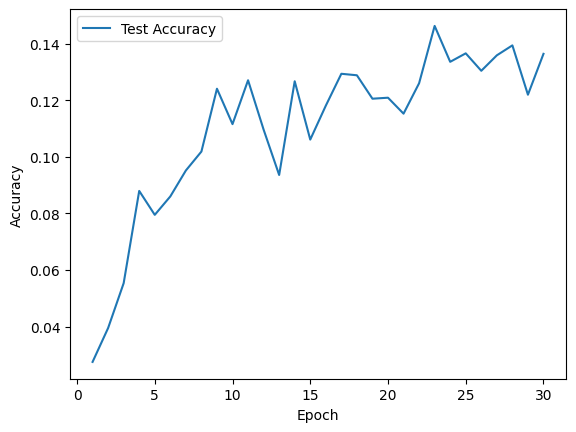

In [9]:
# Train early fusion model
print("Training Early Fusion Model:")
train_early_fusion(train_loader, test_loader, text_input_size, image_input_size, output_size, num_epochs=30, multilabel=multilabel)

Training Late Fusion Model:
The number of parameters of the model are: 375795
Epoch 1/30 - Test Accuracy: 0.0197
Epoch 2/30 - Test Accuracy: 0.0333
Epoch 3/30 - Test Accuracy: 0.0395
Epoch 4/30 - Test Accuracy: 0.0797
Epoch 5/30 - Test Accuracy: 0.0592
Epoch 6/30 - Test Accuracy: 0.0695
Epoch 7/30 - Test Accuracy: 0.0991
Epoch 8/30 - Test Accuracy: 0.0878
Epoch 9/30 - Test Accuracy: 0.0712
Epoch 10/30 - Test Accuracy: 0.1070
Epoch 11/30 - Test Accuracy: 0.1031
Epoch 12/30 - Test Accuracy: 0.1225
Epoch 13/30 - Test Accuracy: 0.0980
Epoch 14/30 - Test Accuracy: 0.1222
Epoch 15/30 - Test Accuracy: 0.1170
Epoch 16/30 - Test Accuracy: 0.1215
Epoch 17/30 - Test Accuracy: 0.1119
Epoch 18/30 - Test Accuracy: 0.1130
Epoch 19/30 - Test Accuracy: 0.1174
Epoch 20/30 - Test Accuracy: 0.1237
Epoch 21/30 - Test Accuracy: 0.1160
Epoch 22/30 - Test Accuracy: 0.1266
Epoch 23/30 - Test Accuracy: 0.1239
Epoch 24/30 - Test Accuracy: 0.1237
Epoch 25/30 - Test Accuracy: 0.1236
Epoch 26/30 - Test Accuracy: 0.

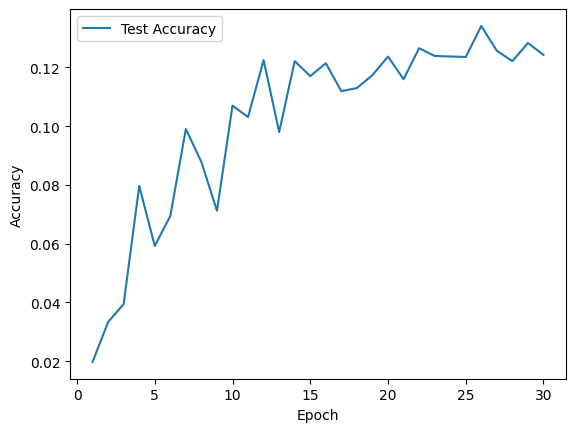

In [11]:
# Train late fusion model
print("Training Late Fusion Model:")
train_late_fusion(train_loader, test_loader, text_input_size, image_input_size, output_size, num_epochs=30, multilabel=multilabel)